# Introduction to machine learning

*Maxime Sangnier*

October, 2017

## Practical session 6: DBSCAN and model selection for clustering

# Table of contents
1. [The elbow method and the silhouette coefficient](#part1)
1. [Model selection for spectral clustering](#part2)


# The elbow method and the silhouette coefficient <a id="part1"></a>


In [3]:
from mllab import *

In [4]:
from sklearn.datasets import make_blobs, make_moons

blobs = make_blobs(n_samples=300, centers=10, cluster_std=0.7)[0]
moons1 = make_moons(n_samples=100, noise=0.05)[0]*3
moons1[:, 0] += 15
moons2 = make_moons(n_samples=100, noise=0.05)[0]*3
moons2[:, 1] -= 15
noise = np.random.rand(20, 2) * 30 - 15

X = np.concatenate((blobs,moons1, moons2, noise))

>Provide an [agglomerative clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) of the data matrix $X$ with 14 clusters.
Plot this clustering with the function defined above.

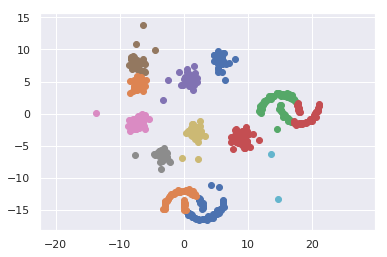

In [5]:
# Answer
from sklearn.cluster import AgglomerativeClustering

clt = AgglomerativeClustering(n_clusters=14)
y_pred = clt.fit_predict(X)

plotXY(X, y_pred, legend=False)

>Write a function `intraclass_inertia(X, y)`, that, given a data matrix $X$ and a vector of labels $y$ (the clustering), computes the empirical intraclass inertia.

In [5]:
# Answer
def intraclass_inertia(X, y):
    Z = X.copy()
    for id_class in range(y.min(), y.max()+1):
        Z[y==id_class] -= Z[y==id_class].mean()
    return np.linalg.norm(Z, 'fro')**2 / Z.shape[0]   

>Still for an [agglomerative clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) technique, draw (on the same picture and with an adequate rescaling) the intraclass inertia and the [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) with respect to the number of clusters.

>Are these two curves consistent (think of the elbow method)?

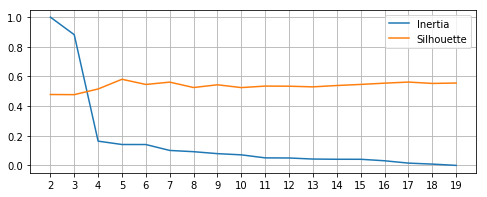

In [8]:
# Answer
from sklearn.metrics import silhouette_score

n_clusters = np.arange(2, 20, step=1)
inertia = []
silhouette = []
for k in n_clusters:
    clt = AgglomerativeClustering(n_clusters=k)
    y_pred = clt.fit_predict(X)
    inertia.append(intraclass_inertia(X, y_pred))
    silhouette.append(silhouette_score(X, y_pred))
inertia = np.r_[inertia]
silhouette = np.r_[silhouette]
    
plt.figure(figsize=(8, 3))
#plt.plot(n_clusters[1:], np.diff(inertia), label="Inertia")
plt.plot(n_clusters, (inertia - inertia.min()) / (inertia.max()-inertia.min()),
         label="Inertia")
plt.plot(n_clusters, silhouette, label="Silhouette")
plt.xticks(n_clusters)
plt.legend(loc="best")

>Write a script, that finds (and prints) the best number of clusters based on the [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score).

>Plot the resulting clustering.
Is it satisfactory?

Best number of clusters: 5


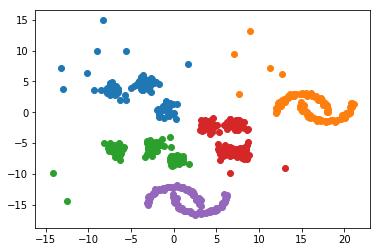

In [9]:
# Answer
k = n_clusters[silhouette == silhouette.max()][0]
print("Best number of clusters:", k)

clt = AgglomerativeClustering(n_clusters=k)
y_pred = clt.fit_predict(X)

plotXY(X, y_pred, legend=False)

>By making $\epsilon$ change in [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), draw (on the same picture and with an adequate rescaling) the intraclass inertia and the [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) with respect to the number of clusters.

>Are these two curves consistent (think of the elbow method)?

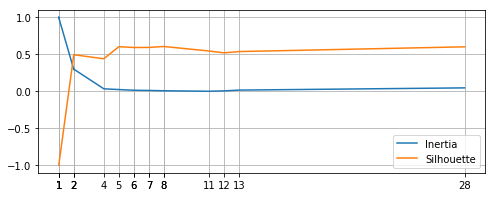

In [10]:
# Answer
from sklearn.cluster import DBSCAN
eps_values = np.linspace(0.5, 5, num=20)

inertia = []
silhouette = []
n_clusters = []
for eps in eps_values:
    clt = DBSCAN(eps=eps)
    y_pred = clt.fit_predict(X)
    if y_pred.max() < 1:
        print('Only noise points with eps =', eps)
        continue
    else:
        inertia.append(intraclass_inertia(X[y_pred>-1], y_pred[y_pred>-1]))
        silhouette.append(silhouette_score(X[y_pred>-1], y_pred[y_pred>-1]))
        n_clusters.append(y_pred.max()+1)
    
inertia = np.r_[inertia]
silhouette = np.r_[silhouette]
n_clusters = np.r_[n_clusters]
    
plt.figure(figsize=(8, 3))
plt.plot(n_clusters, (inertia - inertia.min()) / (inertia.max()-inertia.min()),
         label="Inertia")
plt.plot(n_clusters, silhouette, label="Silhouette")
plt.xticks(n_clusters)
plt.legend(loc="best")

>Write a script, that finds (and prints) the best number of clusters along with the best value of $\epsilon$ based on the [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score).

>Plot the resulting clustering.
Add noisy points in black.
Is it satisfactory?

Best number of clusters: 8
Best eps: 1.21052631579


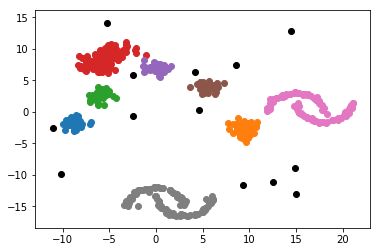

In [9]:
# Answer
k = n_clusters[silhouette == silhouette.max()][0]

eps_values = eps_values[:len(silhouette)]  # Exclude bad values of epsilon
eps = eps_values[silhouette == silhouette.max()][0]

print("Best number of clusters:", k)
print("Best eps:", eps)

clt = DBSCAN(eps=eps)
y_pred = clt.fit_predict(X)

plotXY(X, y_pred, legend=False)
plt.scatter(X[y_pred==-1, 0], X[y_pred==-1, 1], c='k')

>How many noisy points are there?

In [10]:
# Answer
print("Nuimber of noisy points:", (y_pred==-1).sum())

Nuimber of noisy points: 13


# Model selection for spectral clustering <a id="part2"></a>


>Given the following dataset and the function for extracting the affinity matrix and the Laplacian matrices, highlight the gap heuristic of [spectral clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering) in order to choose the number of clusters.
For this purpose, plot the first eigenvalues (let say $\frac n5$, where $n$ is the sample size) of the Laplacian matrices for a nearest neighbor and a Gaussian similarity graph.

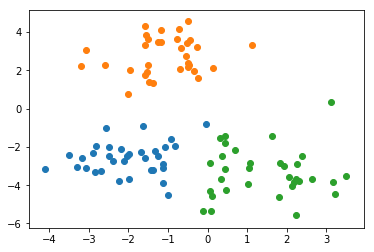

In [11]:
# Dataset
X, y = make_blobs()
plotXY(X, y, legend=False)

In [12]:
from scipy.sparse.csr import csr_matrix

def compute_laplacians(clt):
    """Extract the affinity matrix W from the spectral clustering object clt and returns
    (W, L, Ls, Lw), where, given the degree matrix D:
    - L = D-W is the unnormalized Laplacian of the graph defined by the affinity matrix W.
    - Ls = D^{-1/2}WD^{-1/2} is the normalized Laplacian of the graph (Version 1).
    - Lw = D^{-1}W is the normalized Laplacian of the graph (Version 2).
    """
    if type(clt.affinity_matrix_) is csr_matrix:
        W = np.asarray(clt.affinity_matrix_.todense())
    else:
        W = clt.affinity_matrix_
    
    D = np.diag(np.sum(W, axis=0))  # Degree matrix
    Dinv = np.diag(1/np.diag(D))  # Inverse of the degree matrix
    
    L = D - W  # Unnormalized Laplacian
    Ls = np.sqrt(Dinv).dot(L.dot(np.sqrt(Dinv)))  # Normalized Laplacian (Version 1)
    Lw = Dinv.dot(L)  # Normalized Laplacian (Version 2)
    return W, L, Ls, Lw

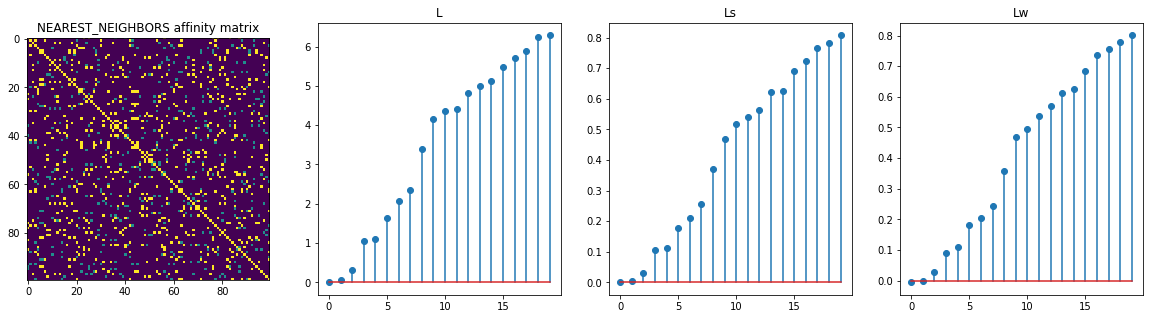

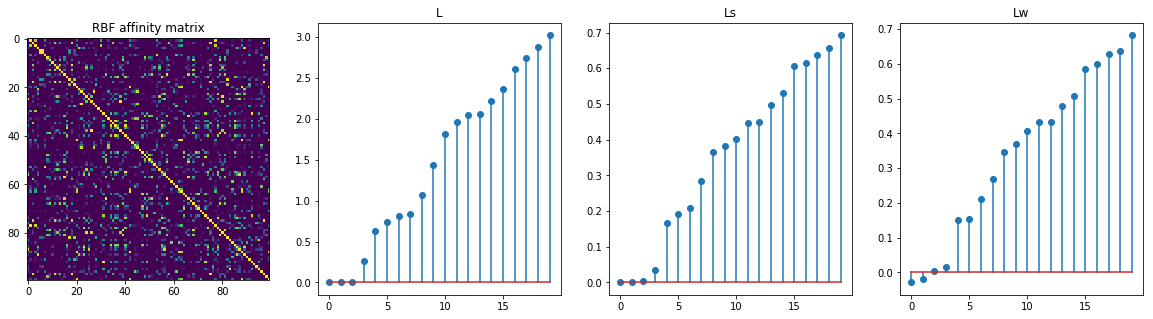

In [13]:
# Answer
from sklearn.cluster import SpectralClustering

for clt in [SpectralClustering(affinity="nearest_neighbors"),
           SpectralClustering(affinity="rbf")]:
    # Compute the affinity matrix on the training sample
    clt.fit(X)
    W, L, Ls, Lw = compute_laplacians(clt)
    
    # Display the affinity matrix as an image
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(W)
    plt.title(clt.affinity.upper() + " affinity matrix")
    
    for it, (title, mat) in enumerate([("L", L), ("Ls", Ls), ("Lw", Lw)]):
        plt.subplot(1, 4, it+2)
        plt.stem(np.linalg.eigvalsh(mat)[:mat.shape[0]//5])
        plt.title(title)


>Compare the eigenvalues of $L_s$ and $L_w$.
What can you conclude?

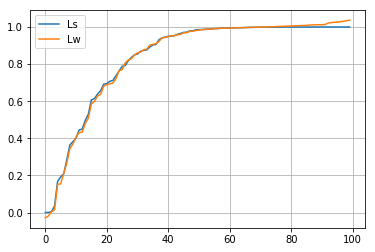

In [14]:
# Answer
for title, mat in [("Ls", Ls), ("Lw", Lw)]:
    plt.plot(np.linalg.eigvalsh(mat), label=title)
plt.legend(loc="best")

**Answer**

Eigenvalues seem similar, which is known theoretically. However, since some eigenvalues for Lw are negative, it seems that there are instabilities in diagonalizing Lw.